In [205]:
import matplotlib.pyplot as plt
from matrix_control import transposeMatrix, printMatrix, reshapeMatrix, sumMatrix
# from model import LinearModel

In [206]:
train_image = []
sample_num = 1
batch_size = 1
for i in range(sample_num):
    image = plt.imread(fname='./image/pgm/train/train{}.png'.format(i+1))
    image = reshapeMatrix(image, 1, 256)[0]
    train_image.append(image)
train_image = transposeMatrix(train_image)

In [207]:
len(train_image[0])

1

In [208]:
# 정답 레이블.
# label = ['t', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
#          't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
#          't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
#          't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
#          't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
#          't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
#          't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
#          't', 'u', 'v', 'w', 'x', 'y', 'z']

label = ['t']

In [209]:
input_size = 256
hidden_size_1 = 96
hidden_size_2 = 48
output_size = 7
learning_rate = 0.001
epochs = 10

In [210]:
from layer import Neuron, one_hot_encoding
from matrix_control import dimMatrix3to2, matrixDotProduct, multiplyScalar, printMatrix, reshapeMatrix, sumMatrix, transposeMatrix, splitMatrix, subtractMatrix, addMatrix, element_wise_multiply
from utils import ReLU, ReLU_derivatived, sigmoid, Softmax, cross_entropy, calAccuracy
import random


class LinearModel:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, sample_num, batch_size, learning_rate, epochs):
        print("모델 생성 시작. 입력차원 {}개, 1히든차원 {}개, 2히든차원 {}개, 출력층 {}개로, 샘플 개수는 {}개 입니다."
              .format(input_size, hidden_size1, hidden_size2, output_size, sample_num));
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.sample_num = sample_num
        self.batch_size = batch_size
        self.batch_per_count = sample_num // batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs

        start = -2.0
        end = 2.0

        self.w1 = [[random.uniform(start, end) for _ in range(input_size)] for _ in range(hidden_size1)];
        self.w2 = [[random.uniform(start, end) for _ in range(hidden_size1)] for _ in range(hidden_size2)];
        self.w3 = [[random.uniform(start, end) for _ in range(hidden_size2)] for _ in range(output_size)];
        

    def preprocessing(self, X):
        for i in range(len(X)):
            for j in range(len(X[0])):
                X[i][j] = X[i][j] / 255.0
        
        return X
    
    def makeDataloader(self, count, X, label):
        tranposed_X = transposeMatrix(X)
        selected_batch = transposeMatrix(tranposed_X[count*self.batch_size : (count+1)*self.batch_size])
        selected_label = label[count*self.batch_size : (count+1)*self.batch_size]
        return {'X' : selected_batch,
                'label' : selected_label}
    
    def makeOutputs(self, outputs, transposed_matrix):
        for row in transposed_matrix:
            outputs.append(row)

    def forward(self, X, label):
        labeled_list = one_hot_encoding(label=label)
        # X = self.preprocessing(X)

        loss_val = []
        count_val = []
        for i in range(self.epochs): 
            print('epochs : {}'.format(i+1))

            dict = {}
            cache = {
                'dw_1' : [[0.0 for _ in range(self.input_size)] for _ in range(self.hidden_size1)],
                'dw_2' : [[0.0 for _ in range(self.hidden_size1)] for _ in range(self.hidden_size2)],
                'dw_3' : [[0.0 for _ in range(self.hidden_size2)] for _ in range(self.output_size)]
            }
            outputs = []
            
            for j in range(self.batch_per_count):
                Dataloader = self.makeDataloader(j, X, label)
                dict = self.propagate(Dataloader['X'])
                self.backpropagate(label=Dataloader['label'], dict=dict, cache=cache)

                self.makeOutputs(outputs, transposeMatrix(dict['a3']))
                if i%5 == 0 and j == self.batch_per_count - 1:
                    loss = 0
                    for i in range(len(outputs)):
                        loss += cross_entropy(prob_dist_predicted=outputs[i], prob_dist_true=labeled_list[i])
                    loss_val.append(loss)
                    print(f'training loss : {loss}')

                    count = calAccuracy(result=outputs, label=label)
                    count_val.append(count)

            # gradient 평균 내서 경사하강법 수행
            cache['dw_1'] = multiplyScalar(matrix=cache['dw_1'], scalar=1/self.batch_per_count)
            cache['dw_2'] = multiplyScalar(matrix=cache['dw_2'], scalar=1/self.batch_per_count)
            cache['dw_3'] = multiplyScalar(matrix=cache['dw_3'], scalar=1/self.batch_per_count)
            self.w1 = subtractMatrix(self.w1, multiplyScalar(matrix=cache['dw_1'], scalar=self.learning_rate))
            self.w2 = subtractMatrix(self.w2, multiplyScalar(matrix=cache['dw_2'], scalar=self.learning_rate))
            self.w3 = subtractMatrix(self.w3, multiplyScalar(matrix=cache['dw_3'], scalar=self.learning_rate))
        
        return loss_val, count_val


    def propagate(self, X):
        dict = {}

        z1 = matrixDotProduct(self.w1, X)
        a1 = ReLU(z1)

        z2 = matrixDotProduct(self.w2, a1)
        a2 = ReLU(z2)

        z3 = matrixDotProduct(self.w3, a2)
        a3 = sigmoid(z3)

        # a3 = Softmax(transposeMatrix(a3))

        dict = {
            'a0' : X,
            'z1' : z1,
            'a1' : a1,
            'z2' : z2,
            'a2' : a2,
            'z3' : z3,
            'a3' : a3
        }

        return dict


    def backpropagate(self, label, dict, cache):
        labeled_list = one_hot_encoding(label=label)

        # dz, dw 구하기. chain rule
        
        #  dict['a3'] = output X sample
        # label_list = sample X output
        # output X sample
        dz_3 = transposeMatrix( subtractMatrix( matrix1=transposeMatrix(dict['a3']), matrix2=labeled_list ) )
        dw_3 = matrixDotProduct(dz_3, transposeMatrix(dict['a2']))
        da_2 = matrixDotProduct(transposeMatrix(self.w3), dz_3)

        dz_2 = element_wise_multiply( da_2, ReLU_derivatived( dict['z2'] ) )
        # dw_2 = multiplyScalar( matrixDotProduct ( dz_2, transposeMatrix(dict['a1']) ), 1/self.sample_num)
        dw_2 = matrixDotProduct( dz_2, transposeMatrix(dict['a1']) )
        da_1 = matrixDotProduct( transposeMatrix(self.w2), dz_2 )

        dz_1 = element_wise_multiply( da_1, ReLU_derivatived( dict['z1'] ) )
        # dw_1 = multiplyScalar( matrixDotProduct( dz_1, transposeMatrix(dict['a0']) ), 1/self.sample_num)
        dw_1 = matrixDotProduct( dz_1, transposeMatrix(dict['a0']) )
        da_0 = matrixDotProduct( transposeMatrix(self.w1), dz_1 )

        # 가중치 업데이트
        cache['dw_1'] = addMatrix(cache['dw_1'], dw_1)
        cache['dw_2'] = addMatrix(cache['dw_2'], dw_2)
        cache['dw_3'] = addMatrix(cache['dw_3'], dw_3)
    
    def test(self, test_data, test_label):
        # 테스트 데이터를 받아서 검증 작업을 실시한다.
        dict = self.propagate(X=test_data)

        return dict['a3']

In [211]:
model = LinearModel(input_size=input_size, hidden_size1=hidden_size_1, hidden_size2=hidden_size_2, output_size=output_size, sample_num=sample_num, batch_size=batch_size, learning_rate=learning_rate, epochs=epochs)
loss_val, count_val = model.forward(train_image, label)

모델 생성 시작. 입력차원 256개, 1히든차원 96개, 2히든차원 48개, 출력층 7개로, 샘플 개수는 1개 입니다.
epochs : 1
[[3.2621409152252693e-37, 2.7079074066626913e-120, 1.0, 1.0, 1.0, 1.0, 1.0]]
[[1, 0, 0, 0, 0, 0, 0]]


ValueError: Number of columns in the first matrix must be equal to the number of rows in the second matrix.

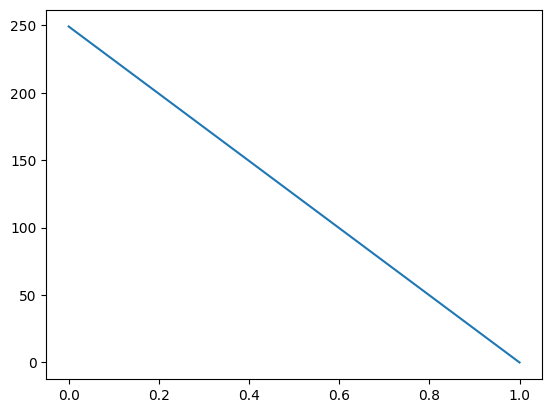

In [ ]:
plt.plot(loss_val, label="loss")

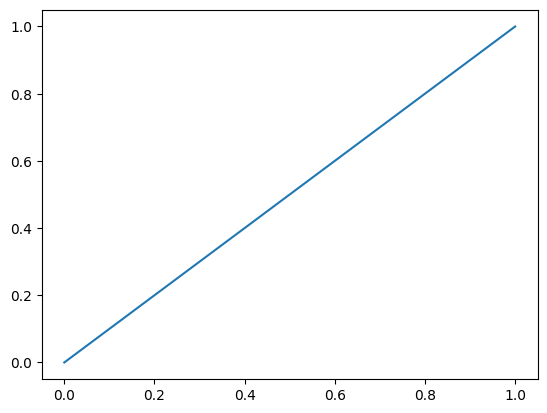

In [ ]:
plt.plot(count_val, label="True count")

### Test

In [ ]:
test_image = []
sample_num = 21
for i in range(sample_num):
    image = plt.imread(fname='./image/pgm/test/test{}.png'.format(i+1))
    image = reshapeMatrix(image, 1, 256)[0]
    test_image.append(image)
test_image = transposeMatrix(test_image)

test_label = ['t', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z']

test_result = model.test(test_data=test_image, test_label=test_label)

print(len(test_result))
print(len(test_result[0]))

7
21


In [ ]:
calAccuracy(result=transposeMatrix(test_result), label=test_label)

정답 개수 : 1


1

In [ ]:
model.w3

[[-1.7839926100215646,
  -0.6766595693182862,
  -0.5317203481198277,
  1.5135868765499616,
  0.9485024814646523,
  -0.3538717647310601,
  1.5998857584356192,
  0.889025249183124,
  0.5756231777023633,
  -1.9885583861957332,
  1.955013873768924,
  1.794576702892929,
  -1.310552121909871,
  -1.3369979383971513,
  1.5063982654243535,
  0.252372136146968,
  -0.493924508047315,
  0.606030919525304,
  -0.41541919829030416,
  1.8546290534334995,
  1.5763338930688273,
  -1.5041059523680618,
  1.1793188305416944,
  0.5528079342109384,
  -1.3308721128536276,
  -1.786831879442559,
  0.8305510325960781,
  0.426401484662001,
  0.5311048377842221,
  0.8403704058965882,
  -0.22319614402773433,
  1.177197734807414,
  -1.9020537379322437,
  1.3961803473356458,
  -0.15955341946313162,
  -1.4327500671715936,
  1.181609608505461,
  2.0674783226076743,
  0.5612531844334991,
  -1.1651386176999163,
  1.9492133950414385,
  -1.8849344759436044,
  -1.0782687886450597,
  0.9947585237568898,
  -1.4709511312795496